In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models.VQ_VAE import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


## Now I'm plugging my own dataset 

In [ ]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

# Pay attention to executing the right cell for the desired experiment.

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


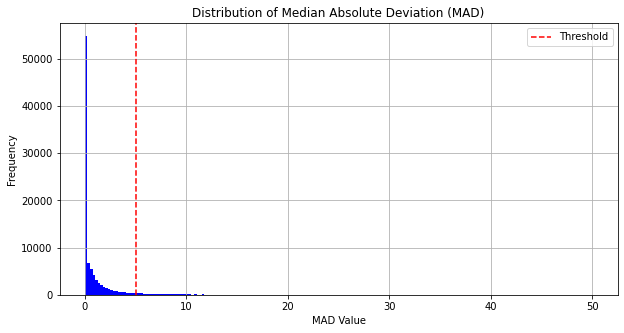

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [2]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

In [ ]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

In [ ]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)


# End of experiment choice

In [3]:
data = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)

In [6]:
# adding my own labels :

metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
num_classes = len(pd.Series(label).unique())

back to the regular notebook

In [7]:
dat = pd.DataFrame(data)
feature_num = dat.shape[1]
data_num = dat.shape[0]
dat = dat.values.reshape(-1,1,feature_num)
print(dat.shape)

(4445, 1, 5914)


In [8]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float() 
        if self.transform:
            out_data1 = self.transform(out_data1)

        return out_data1

In [9]:
train_data, test_data = train_test_split(dat, test_size = 0.3,random_state = 66)
print('train data:',len(train_data))
print('test data:',len(test_data))
train_data_set = Mydatasets(data1 = train_data)
test_data_set = Mydatasets(data1 = test_data)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 32, shuffle=False)

train data: 3111
test data: 1334


In [10]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for m1 mac
DEVICE = torch.device("mps")

out_dim = 512   
VQ_VAE = Model(
            dropout = 0.0,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 64,  
            embedding_dim = 64,   
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(VQ_VAE.parameters(), lr=1e-3, amsgrad=False)
data_variance = np.var(dat)

print(DEVICE)

mps


Added feature to monitor training


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:05<01:48,  5.69s/it]

Epoch 1/20, Training Loss: 33.36714152189401, Validation Loss: 2.3239764656339372


 10%|█         | 2/20 [00:06<00:54,  3.02s/it]

Epoch 2/20, Training Loss: 1.6767271023530226, Validation Loss: 2.0348483125368753


 15%|█▌        | 3/20 [00:07<00:36,  2.16s/it]

Epoch 3/20, Training Loss: 1.1566320932828462, Validation Loss: 0.6547404868262154


 20%|██        | 4/20 [00:09<00:28,  1.76s/it]

Epoch 4/20, Training Loss: 0.6823770541411179, Validation Loss: 0.6173936199574244


 25%|██▌       | 5/20 [00:10<00:23,  1.54s/it]

Epoch 5/20, Training Loss: 0.5981846841482016, Validation Loss: 0.5703643014033636


 30%|███       | 6/20 [00:11<00:19,  1.40s/it]

Epoch 6/20, Training Loss: 0.5657177567481995, Validation Loss: 0.5686453616335279


 35%|███▌      | 7/20 [00:12<00:17,  1.31s/it]

Epoch 7/20, Training Loss: 0.5483858401958759, Validation Loss: 0.5415725041003454


 40%|████      | 8/20 [00:13<00:15,  1.25s/it]

Epoch 8/20, Training Loss: 0.5389747825952677, Validation Loss: 0.5456894167831966


 45%|████▌     | 9/20 [00:14<00:13,  1.21s/it]

Epoch 9/20, Training Loss: 0.5599066890203036, Validation Loss: 0.5645668896890822


 50%|█████     | 10/20 [00:15<00:11,  1.20s/it]

Epoch 10/20, Training Loss: 0.5767661149685199, Validation Loss: 0.5675450421514965


 55%|█████▌    | 11/20 [00:17<00:10,  1.18s/it]

Epoch 11/20, Training Loss: 0.5986691529934223, Validation Loss: 0.6436499754587809


 60%|██████    | 12/20 [00:18<00:09,  1.16s/it]

Epoch 12/20, Training Loss: 0.7585724683908316, Validation Loss: 0.8900800914991469


 65%|██████▌   | 13/20 [00:19<00:08,  1.15s/it]

Epoch 13/20, Training Loss: 0.8191512502156771, Validation Loss: 0.868438055117925


 70%|███████   | 14/20 [00:20<00:06,  1.14s/it]

Epoch 14/20, Training Loss: 0.868419179549584, Validation Loss: 0.920113932518732


 75%|███████▌  | 15/20 [00:21<00:05,  1.14s/it]

Epoch 15/20, Training Loss: 0.8637602696051965, Validation Loss: 0.9126053835664477


 80%|████████  | 16/20 [00:22<00:04,  1.14s/it]

Epoch 16/20, Training Loss: 0.8272097844343919, Validation Loss: 0.9288845722164426


 85%|████████▌ | 17/20 [00:23<00:03,  1.14s/it]

Epoch 17/20, Training Loss: 0.8042837885709909, Validation Loss: 0.9177148143450419


 90%|█████████ | 18/20 [00:25<00:02,  1.14s/it]

Epoch 18/20, Training Loss: 0.7913117202428671, Validation Loss: 0.9327585988101506


 95%|█████████▌| 19/20 [00:26<00:01,  1.14s/it]

Epoch 19/20, Training Loss: 0.7884690486467801, Validation Loss: 0.9082986762126287


100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

Epoch 20/20, Training Loss: 0.7174459374867953, Validation Loss: 0.8083386392820449


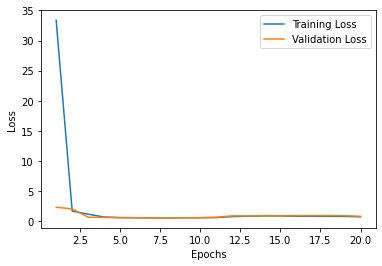

In [11]:
EPOCH = 20
train_res_recon_error = []
val_res_recon_error = []

VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)
    
    # Training loop
    for labels, inputs in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    train_res_recon_error.append(train_loss)
    
    # Validation loop (if you have a validation dataset)
    with torch.no_grad():
        running_val_loss = 0.0
        count = 0
        for labels, inputs in enumerate(test_dataloader, 0):
            inputs = inputs.to(DEVICE)
            vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)
            recon_error = F.mse_loss(data_recon, inputs) / data_variance
            loss = recon_error + vq_loss
            count += 1
            running_val_loss += loss.item()
        
        # Calculate and store validation loss for this epoch
        val_loss = running_val_loss / count
        val_res_recon_error.append(val_loss)
    
    # Print and/or plot training and validation loss
    print(f"Epoch {epoch + 1}/{EPOCH}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
    
# Plot training and validation loss curves
epochs = np.arange(1, EPOCH + 1)
plt.plot(epochs, train_res_recon_error, label='Training Loss')
plt.plot(epochs, val_res_recon_error, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
en_lat = []
en_quantized = []
en_reconstruction = []
data_set = Mydatasets(data1 = dat)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=False) 



#vq_loss, data_recon, perplexity, _, quantized = VQ_VAE(inputs)


for i in range(len(dat)):
    en_data = data_set.dataset[i][0]
    latent_1 = VQ_VAE._encoder(en_data.view(1, 1, feature_num).float().to(DEVICE))
    _, data_recon, _, _,latent_2 = VQ_VAE(en_data.view(1, 1, feature_num).float().to(DEVICE))
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_reconstruction.append(data_recon.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat), -1)
reconstruction_out = np.array(en_quantized)
reconstruction_out = reconstruction_out.reshape(len(dat), -1)

print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

encode_out: (4445, 512)
quantized_out: (4445, 64)


# let's check if the encoding makes sense

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.9091594  0.08419345]
[3.7687016  0.34900367]


/Users/aygalic/Thesis/genome_analysis_parkinson/external_aproach/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


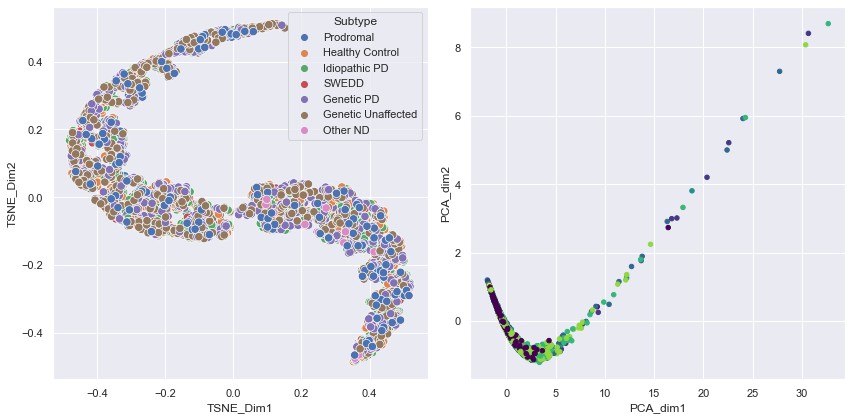

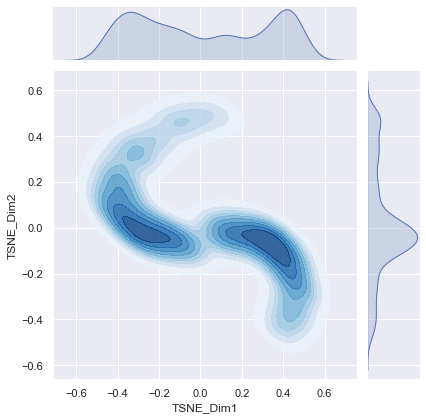

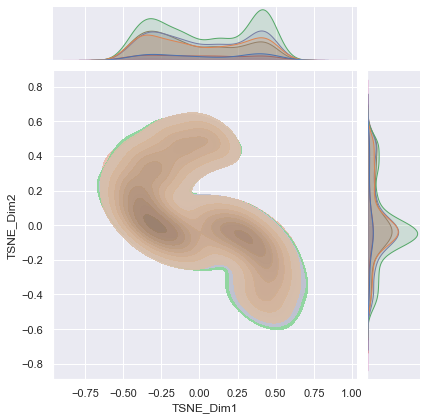

In [21]:
params = {"early_exaggeration":5,
              "learning_rate":1000, 
              "perplexity":50, 
              "min_grad_norm":1e-7, 
              "n_iter":10000,
              "n_components":2}
visualisation.plot_clusters(encode_out, label, params)

In [23]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
#clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = filenames_mask #& clinical_mask

# Apply the combined mask to your dataset
filtered_dat = encode_out[combined_mask]
#filtered_clinical_info = ["Genetic PD"]*sum(combined_mask)
#filtered_clinical_info = ["Idiopathic PD"]*sum(combined_mask)
filtered_clinical_info = clinical_info_series[combined_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1521, 512)
(1521,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[0.9071476  0.08588351]
[3.5560842 0.3366696]


/Users/aygalic/Thesis/genome_analysis_parkinson/external_aproach/../src/utils/visualisation.py:198: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  a = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], marker='o', cmap=my_cmap, c=colors, s=20)


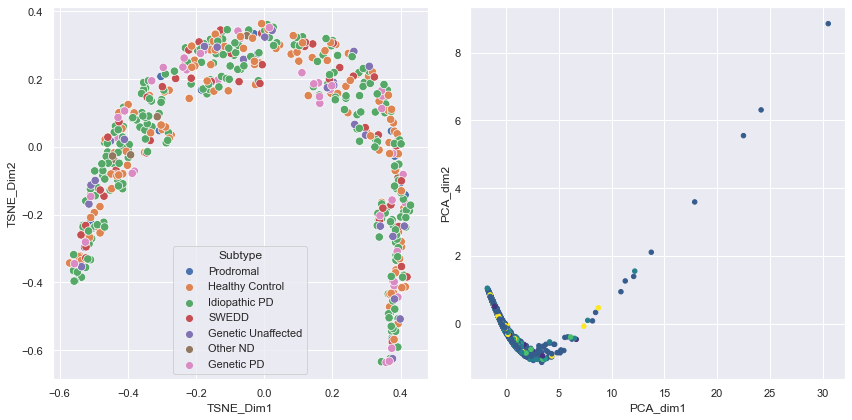

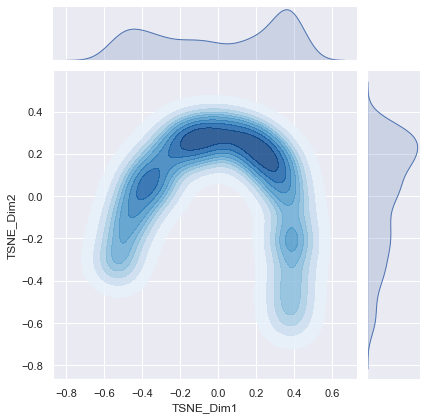

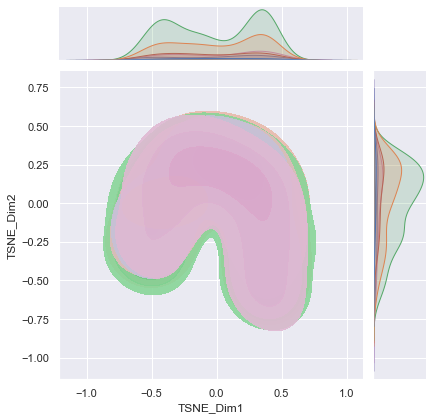

In [24]:
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

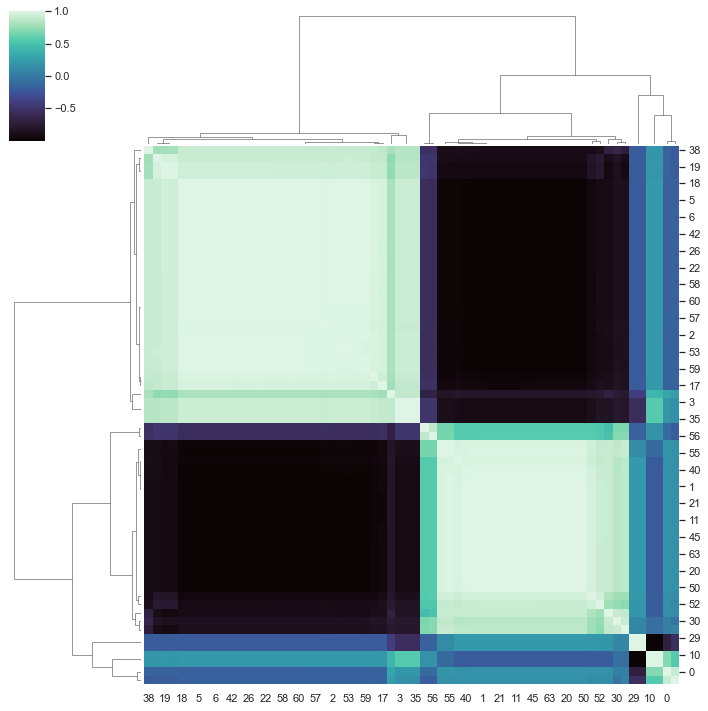

In [25]:
df = pd.DataFrame(quantized_out)
corr = df.corr(method = 'spearman')
sns.clustermap(pd.DataFrame(corr),cmap = 'mako')